In [28]:
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib.figure import figaspect
import numpy as np
import os

try:
    from ncempy.io import dm
except ImportError:
    !pip install ncempy
    from ncempy.io import dm

from scipy import ndimage
from skimage import util, exposure, filters

from IPython.display import display
from ipywidgets import IntSlider, interactive

## High mag (5 MX) HAADF-STEM image of Pt923

<IPython.core.display.Javascript object>


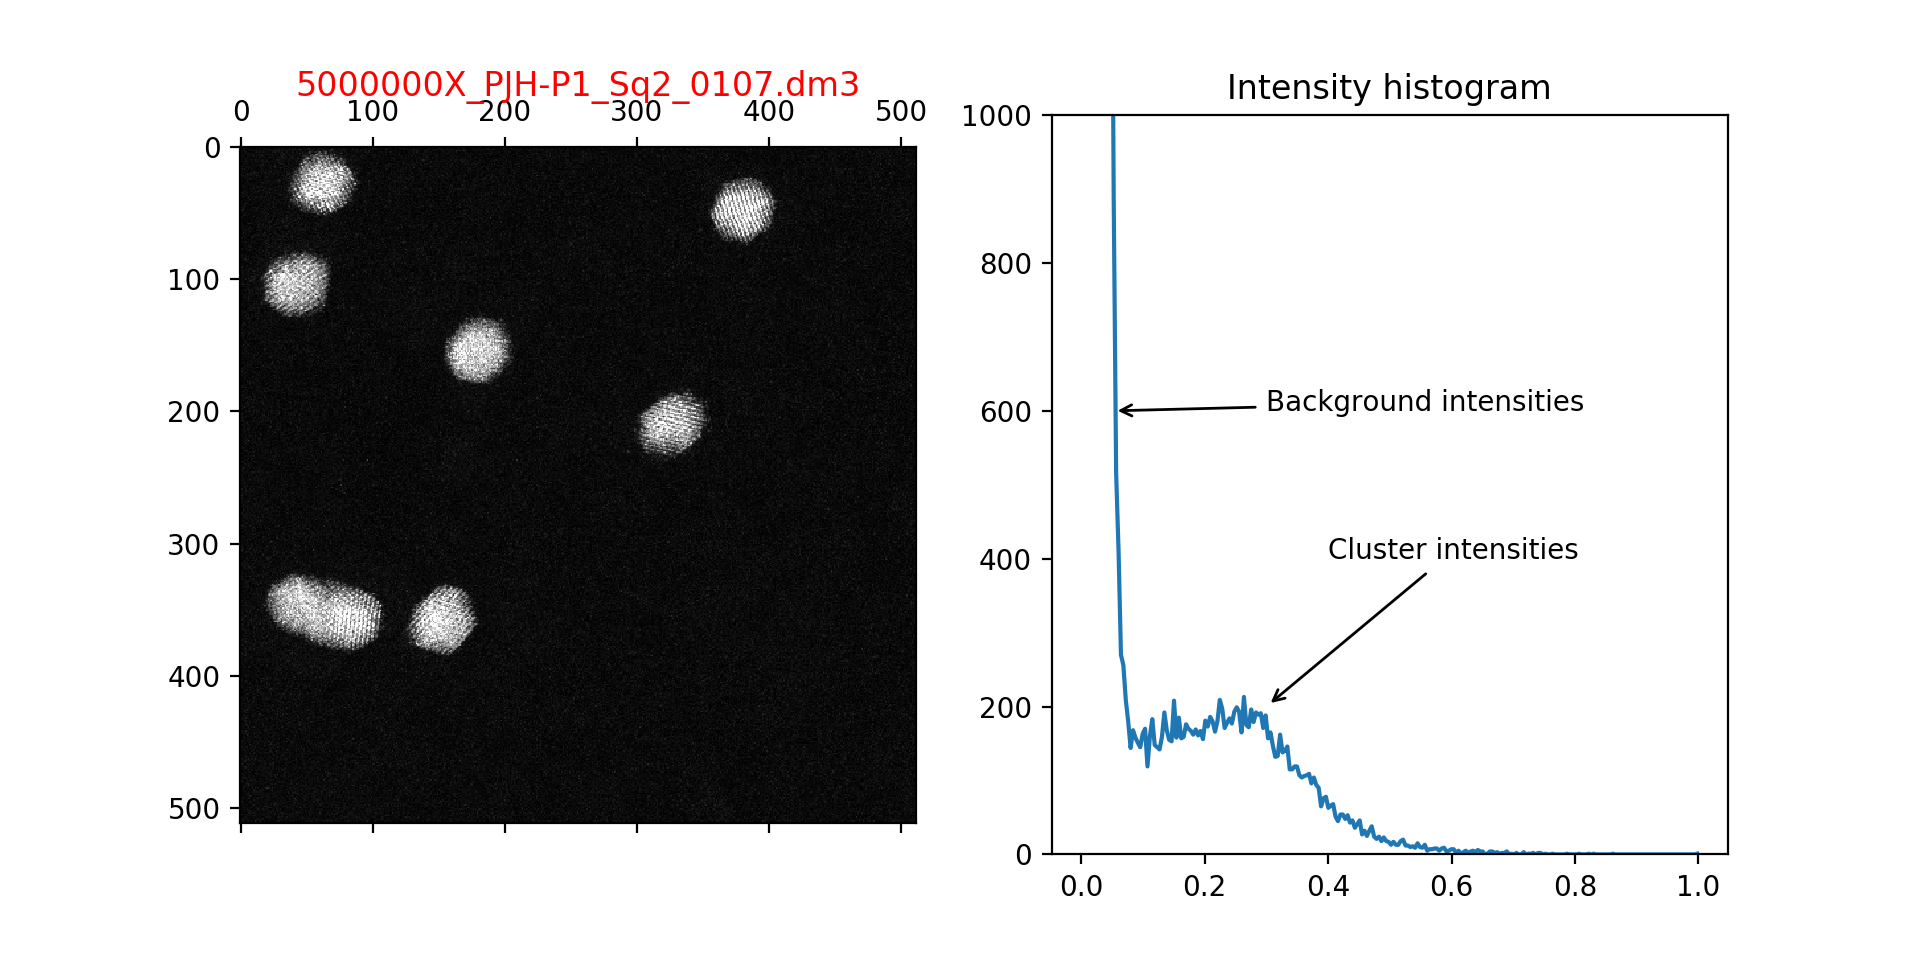

Text(0.3, 600, 'Background intensities')

In [29]:
f = '/Users/pjh523/OneDrive - University of Birmingham/Projects/Pt/EChem/GC/NPL/July_2017/pt923/STEM/DF/5000000X_PJH-P1_Sq2_0107.dm3'

dm3 = dm.dmReader(f)
im = exposure.rescale_intensity(util.img_as_float(dm3['data']))

fig, ax = plt.subplots(ncols=2, figsize=figaspect(1./2))
ax[0].matshow(im, vmax=0.4, cmap='gray')
ax[0].set_title(os.path.basename(f), color='r')

vals, bins = exposure.histogram(im)
ax[1].plot(bins, vals)
ax[1].set_title('Intensity histogram')
ax[1].set_ylim(0, 1000)
ax[1].annotate('Cluster intensities', xy=(0.3, 200), xytext=(0.4, 400),
               arrowprops=dict(arrowstyle='->'))
ax[1].annotate('Background intensities', xy=(0.05, 600), xytext=(0.3, 600),
               arrowprops=dict(arrowstyle='->'))

## The effect of different classifiers in Otsu's threshold

<IPython.core.display.Javascript object>


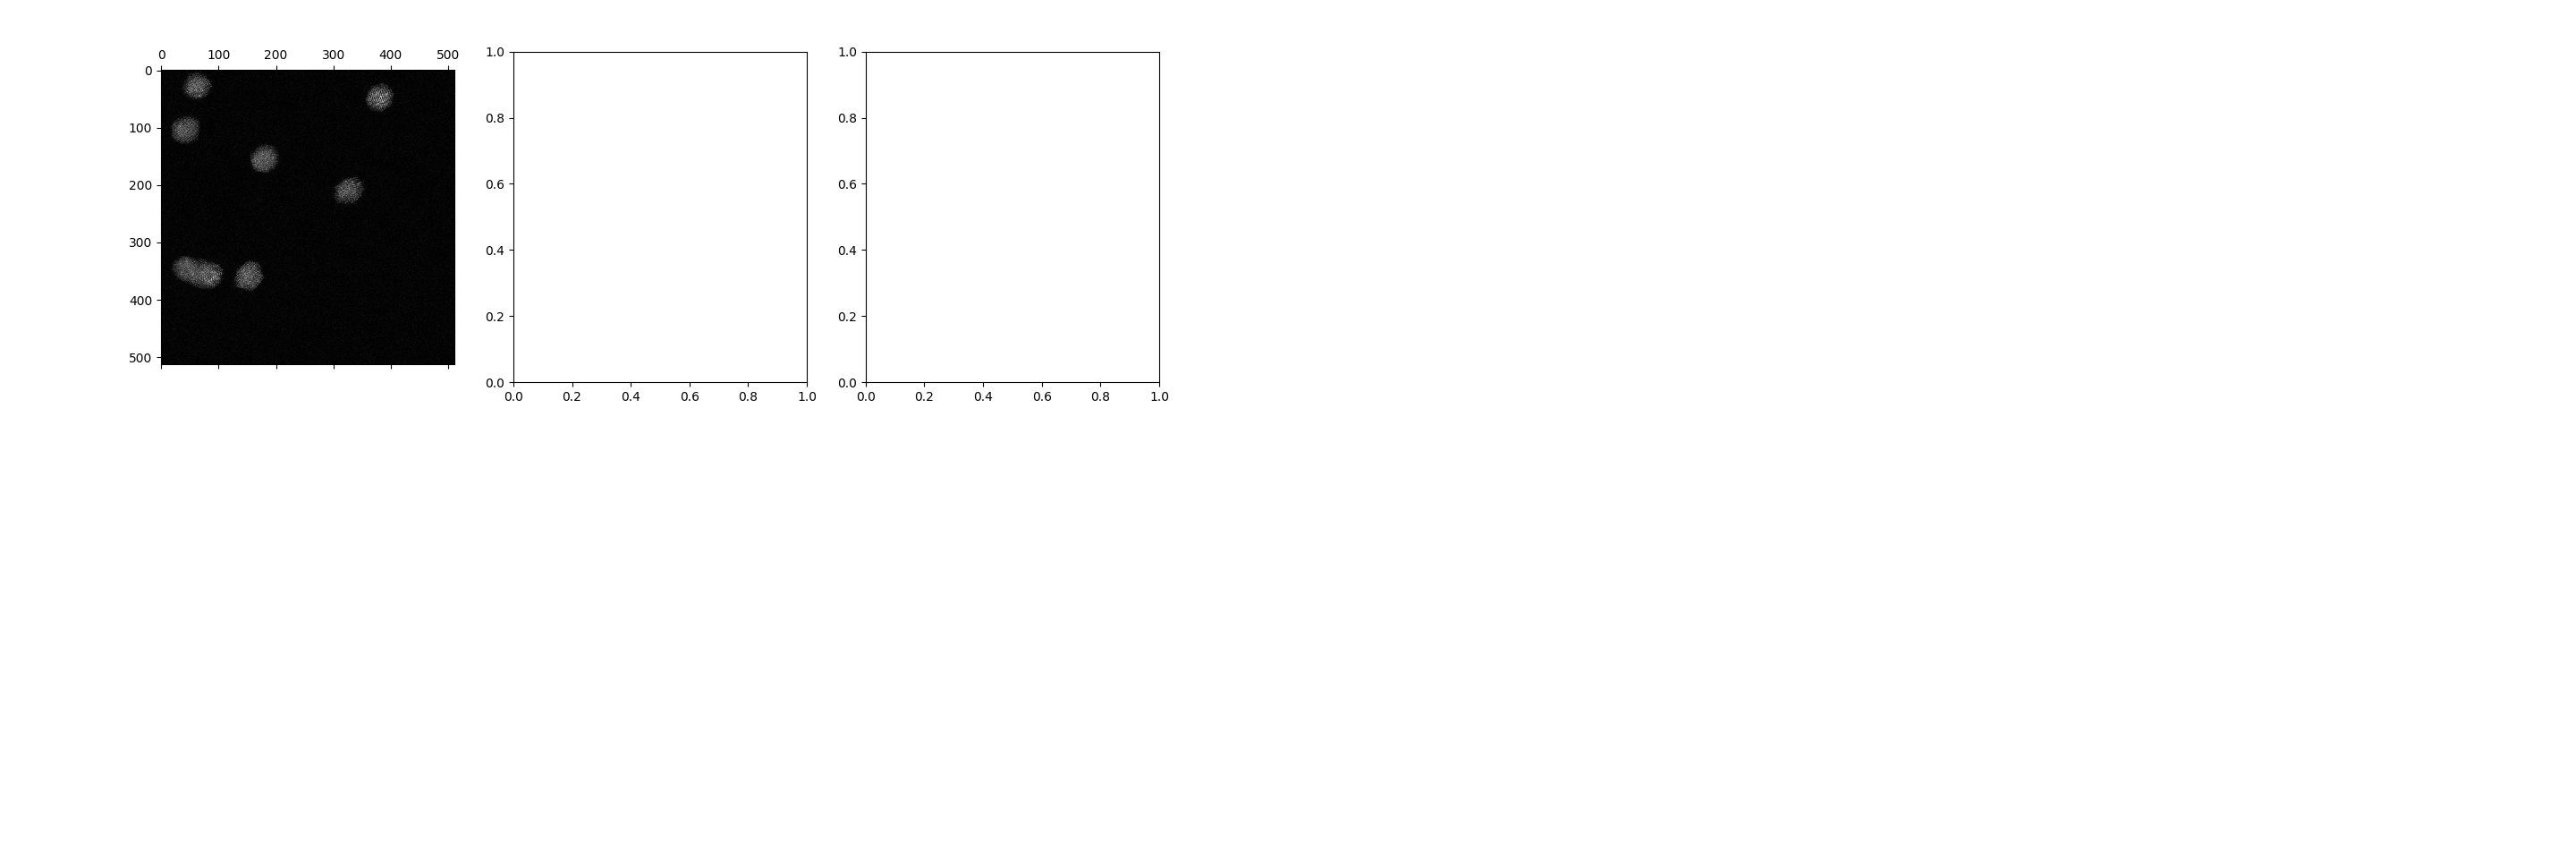

NameError: name 'threshold_otsu_median2' is not defined

In [31]:
fig, ax = plt.subplots(ncols=3, figsize=figaspect(1./3))

ax[0].matshow(im, cmap='gray')

m1 = im > filters.threshold_otsu(im)
m2 = im > threshold_otsu_median2(im)
ax[1].matshow(np.logical_xor(m1, m2))

vals, bins = exposure.histogram(im)
ax[-1].plot(bins, vals)
ax[-1].axvline(filters.threshold_otsu(im), color='k', label='Otsu\'s')
ax[-1].axvline(threshold_otsu_median(im), color='r', label='Otsu\'s modal')
ax[-1].axvline(threshold_otsu_median2(im), color='g', label='Otsu\'s median')
ax[-1].set_xlabel('Intensity/ arb.')
ax[-1].set_ylabel('Counts')
ax[-1].legend()

fatal: destination path 'Python' already exists and is not an empty directory.
